In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import zipfile
from google.colab import drive

%matplotlib inline

In [ ]:
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/datasets/Plant_Diseases_Dataset.zip'
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [ ]:
data_dir = "../content/dataset/Plant_Diseases_Dataset"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [ ]:
print(f"Osztályok: \n{diseases}")

Osztályok: 
['Corn_Common_rust', 'Corn_Healthy', 'Peach_Bacterial_spot', 'Strawberry_Healthy', 'Tomato_Tomato_mosaic_virus', 'Corn_Northern_leaf_blight', 'Grape_Healthy', 'Pepper_Bacterial_spot', 'Corn_Gray_leaf_spot', 'Apple_Black_rot', 'Strawberry_Leaf_scorch', 'Grape_Esca', 'Apple_Healthy', 'Potato_Early_blight', 'Potato_Healthy', 'Tomato_Early_blight', 'Tomato_Spider_mites', 'Tomato_Bacterial_spot', 'Peach_Healthy', 'Grape_Leaf_blight', 'Grape_Black_rot', 'Cherry_Powdery_mildew', 'Apple_Cedar_apple_rust', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Pepper_Healthy', 'Apple_Apple_scab', 'Tomato_Septoria_leaf_spot', 'Tomato_Tomato_Yellow_leaf_curl_virus', 'Tomato_Healthy', 'Potato_Late_blight', 'Cherry_Healthy', 'Tomato_Target_Spot']


In [ ]:
print("Összes betegségosztály: {}".format(len(diseases)))

Összes betegségosztály: 33


In [ ]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('_')[0] not in plants:
        plants.append(plant.split('_')[0])
    if plant.split('_')[1] != 'healthy':
        NumberOfDiseases += 1

In [ ]:
print(f"Egyedi növényfajták: \n{plants}")

Egyedi növényfajták: 
['Corn', 'Peach', 'Strawberry', 'Tomato', 'Grape', 'Pepper', 'Apple', 'Potato', 'Cherry']


In [ ]:
print("Növények száma: {}".format(len(plants)))

Növények száma: 9


In [ ]:
print("Betegségek száma: {}".format(NumberOfDiseases))

Betegségek száma: 33


In [ ]:
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))


img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Corn_Common_rust,1907
Corn_Healthy,1859
Peach_Bacterial_spot,1838
Strawberry_Healthy,1824
Tomato_Tomato_mosaic_virus,1790
Corn_Northern_leaf_blight,1908
Grape_Healthy,1692
Pepper_Bacterial_spot,1913
Corn_Gray_leaf_spot,1642
Apple_Black_rot,1987


In [ ]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"{n_train} darab kép áll rendelkezésre tanításhoz")

60930 darab kép áll rendelkezésre tanításhoz


In [ ]:
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

In [ ]:
img, label = train[0]
print(f"Képek mérete: {img.shape} {label}")

Képek mérete: torch.Size([3, 256, 256]) 0


In [ ]:
random_seed = 7
torch.manual_seed(random_seed)

In [ ]:
batch_size = 32

In [ ]:
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [ ]:
def get_default_device():
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))


In [ ]:
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True)
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True)
        self.conv4 = ConvBlock(256, 512, pool=True)
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(train.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))


    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            sched.step()


        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history


In [ ]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 51.8 s, sys: 3.75 s, total: 55.6 s
Wall time: 1min 1s


[{'val_loss': tensor(3.4967, device='cuda:0'), 'val_accuracy': tensor(0.0286)}]

In [ ]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=1e-4,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00812, train_loss: 0.7263, val_loss: 1.3127, val_acc: 0.8048
Epoch [1], last_lr: 0.00000, train_loss: 0.1116, val_loss: 1.1810, val_acc: 0.9307
CPU times: user 15min 24s, sys: 11min 47s, total: 27min 12s
Wall time: 27min 52s


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss').cpu().item() if isinstance(x.get('train_loss'), torch.Tensor) else x.get('train_loss') for x in history]
    val_losses = [x.get('val_loss').cpu().item() if isinstance(x.get('val_loss'), torch.Tensor) else x.get('val_loss') for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

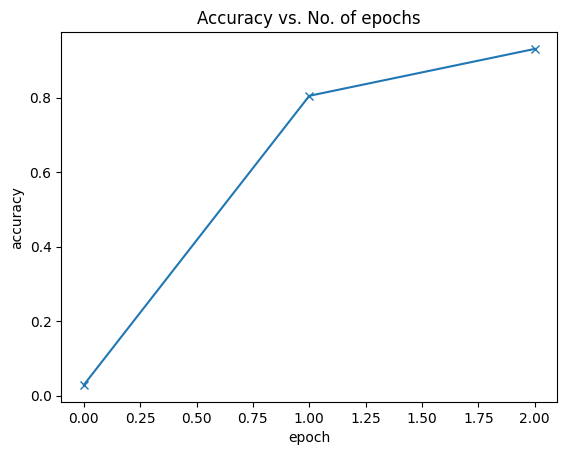

In [ ]:
plot_accuracies(history)

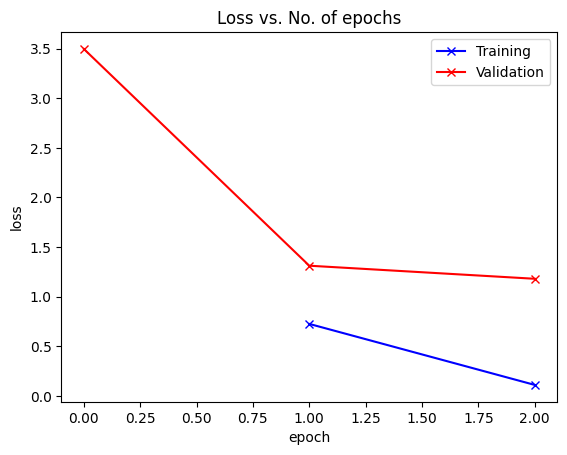

In [ ]:
plot_losses(history)

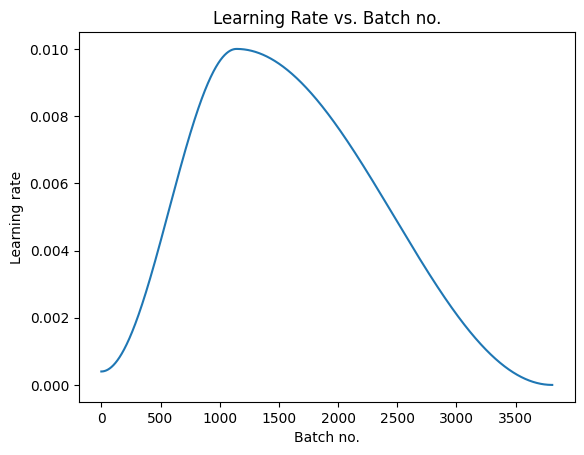

In [ ]:
plot_lrs(history)

In [ ]:
PATH = '../content/model/plant-disease-model.pth'
torch.save(model.state_dict(), PATH)